# Analysis of Yelp Business Intelligence Data by Sky Song

In this notebook, We will analyze a subset of Yelp's business, reviews and user data. \
This dataset comes from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) \
I took steps to pull this data into s3 bucket: ('s3://sta9760yelpdatasetsky/yelp/')\
Total of 11GB Data

# Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install `pandas` and `matplotlib`

In [1]:
%%info

In [2]:
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("pandas==1.0.3")


VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1638207336197_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# "you can run the latest version of seaborn but before that you only need to run another package which is scipy."

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
sc.install_pypi_package("scipy==1.7.0")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
sc.install_pypi_package("seaborn==0.11.2")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Importing

Now, import the installed packages from the previous block below.

In [90]:
import matplotlib
import pandas
import scipy
import seaborn
import numpy as np

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data

Now, import the installed packages from the previous block below.

In [68]:
df1 = spark.read.json('s3://sta9760yelpdatasetsky/yelp/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Overview of Data

Display the number of rows and columns in our dataset.

In [69]:
print(f'Columns: {len(df1.dtypes)} | Rows: {df1.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Columns: 14 | Rows: 160,585

In [70]:
df1.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

* `business_id`
* `name`
* `city`
* `state`
* `categories`

To really see no null value in name, city, state and categories:

In [71]:
df1.createOrReplaceTempView("business")
output = spark.sql('select business_id,name,city,state,stars,categories from business WHERE business_id != "null" and name != "null" and city != "null" and state != "null" and categories != "null" limit 5')
output.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----------+-----+-----+--------------------+
|         business_id|                name|       city|state|stars|          categories|
+--------------------+--------------------+-----------+-----+-----+--------------------+
|6iYb2HFDywm3zjuRg...| Oskar Blues Taproom|    Boulder|   CO|  4.0|Gastropubs, Food,...|
|tCbdrRPZA0oiIYSmH...|Flying Elephants ...|   Portland|   OR|  4.0|Salad, Soup, Sand...|
|bvN78flM8NLprQ1a1...|      The Reclaimory|   Portland|   OR|  4.5|Antiques, Fashion...|
|oaepsyvc0J17qwi8c...|         Great Clips|Orange City|   FL|  3.0|Beauty & Spas, Ha...|
|PE9uqAjdw0E4-8mjG...|   Crossfit Terminus|    Atlanta|   GA|  4.0|Gyms, Active Life...|
+--------------------+--------------------+-----------+-----+-----+--------------------+

# Analyzing Categories

Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

* How many businesses are categorized as `Active Life`, for instance
* What are the top 20 most popular categories available?

## Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

In [72]:
associationTable = spark.sql("select business_id,explode(split(categories,', ')) as category from business")
associationTable.createOrReplaceTempView("categories")
output = spark.sql("select * from categories limit 5")
output.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+
|         business_id|    category|
+--------------------+------------+
|6iYb2HFDywm3zjuRg...|  Gastropubs|
|6iYb2HFDywm3zjuRg...|        Food|
|6iYb2HFDywm3zjuRg...|Beer Gardens|
|6iYb2HFDywm3zjuRg...| Restaurants|
|6iYb2HFDywm3zjuRg...|        Bars|
+--------------------+------------+

## Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [73]:
total = spark.sql("select distinct category from categories")
print(total.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1330

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category

So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [74]:
output = spark.sql("select category, count(*) as count from categories group by category")
output.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            category|count|
+--------------------+-----+
|      Dermatologists|  351|
|      Paddleboarding|   67|
|        Aerial Tours|    8|
|         Hobby Shops|  610|
|          Bubble Tea|  779|
|             Embassy|    9|
|             Tanning|  701|
|            Handyman|  507|
|      Aerial Fitness|   13|
|             Falafel|  141|
|        Summer Camps|  308|
|       Outlet Stores|  184|
|     Clothing Rental|   37|
|      Sporting Goods| 1864|
|     Cooking Schools|  114|
|  College Counseling|   20|
|  Lactation Services|   47|
|Ski & Snowboard S...|   55|
|             Museums|  336|
|              Doulas|   52|
+--------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

In [75]:
from matplotlib import pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [76]:
top_df = spark.sql("select category, count(*) as count from categories group by category order by count(*) desc limit 20")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [77]:
top_df2 = top_df.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

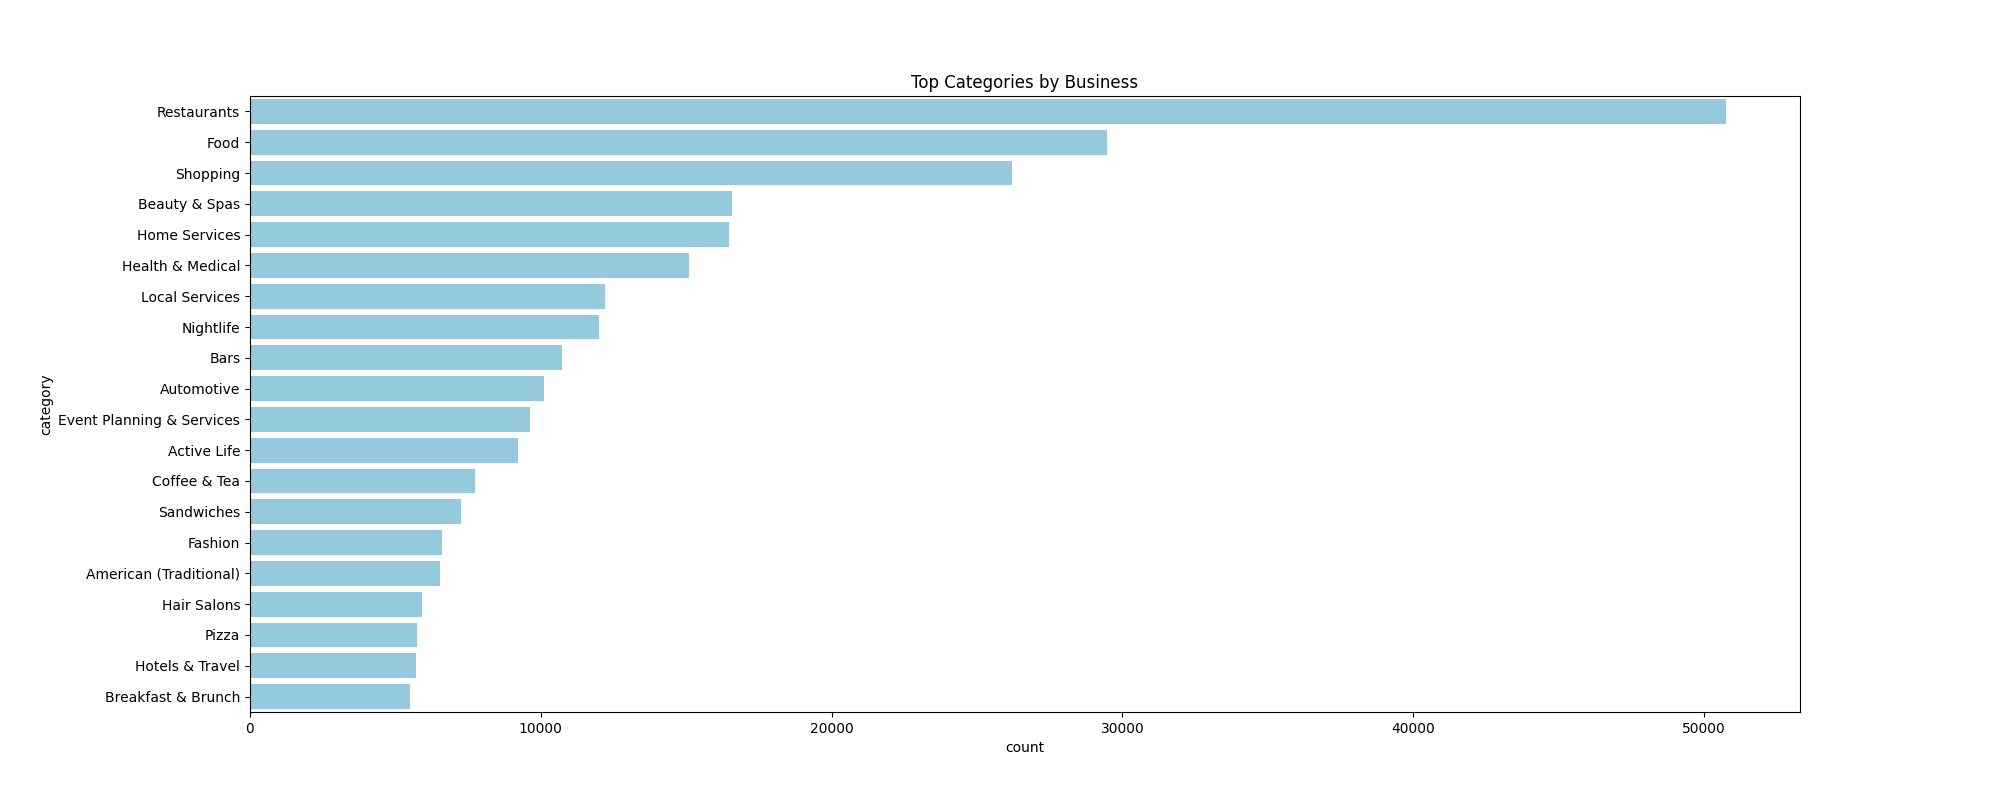

In [78]:
fig, ax = plt.subplots(figsize = (20,8))
top_cate_plot = seaborn.barplot(x = 'count', y = 'category', data = top_df2, ax = ax, color = 'skyblue')
ax.set_title('Top Categories by Business')
%matplot plt

# Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely _dissatisfied_ or extremely _satisfied_ with the service received. 

How true is this really? Let's try and answer this question.

## Loading User Data

Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [19]:
# User data not quie like same as professor's notebook 
# It is the review one

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
# Choose review and look like same as professor guidline 
df2 = spark.read.json('s3://sta9760yelpdatasetsky/yelp/yelp_academic_dataset_review.json')
df2.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

In [22]:
df2.createOrReplaceTempView("review")
output = spark.sql('select business_id, stars from review limit 5')
output.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|DiRIdYhGyuTNZurKy...|  3.0|
|bPmWDBkjBhV11Yk4B...|  5.0|
|xHdKDNcJrvkYJkAGs...|  4.0|
|Irp5sgl7XASH5ZTw2...|  5.0|
|R8fLQ6TLz06MQR69K...|  3.0|
+--------------------+-----+

Now, let's aggregate along the `stars` column to get a resultant dataframe that displays _average stars_ per business as accumulated by users who **took the time to submit a written review**.

In [23]:
output = spark.sql('select business_id, avg(stars) as avgStars from review group by business_id')
output.createOrReplaceTempView("averageReview")
output1 = spark.sql('select * from averageReview limit 5')
output1.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------------+
|         business_id|         avgStars|
+--------------------+-----------------+
|yWG3JLNsqEkU1Y8wj...|3.423076923076923|
|4jQ1y1_ItTCj3C9Xl...|             3.28|
|ZmRWz7YKDbc_ONBS1...|              4.0|
|DT-WVQB-R_iiShvCo...|              1.8|
|-2ysHxktRcDom1m9A...|              5.0|
+--------------------+-----------------+

Now the fun part - let's join our two dataframes (reviews and business data) by business_id.



In [24]:
output = spark.sql('''select rev.*, bus.stars, bus.name, bus.city, bus.state 
                        from business as bus 
                        left outer join averageReview as rev 
                        on bus.business_id = rev.business_id''')
output.createOrReplaceTempView("joinedOutput")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
output = spark.sql('select avgStars, stars, name, city, state from joinedOutput WHERE name != "null" and city != "null" and state != "null" limit 5')
output.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+----------+-----+
|          avgStars|stars|                name|      city|state|
+------------------+-----+--------------------+----------+-----+
|               5.0|  5.0|    CheraBella Salon|   Peabody|   MA|
|             3.875|  4.0|Mezcal Cantina & ...|  Columbus|   OH|
|3.8666666666666667|  4.0|    Red Table Coffee|    Austin|   TX|
|               5.0|  5.0|          WonderWell|    Austin|   TX|
|             3.375|  3.5|         Avalon Oaks|Wilmington|   MA|
+------------------+-----+--------------------+----------+-----+

Let's see a few of these:

Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [26]:
skew_df = spark.sql("select (avgStars-stars)/stars from joinedOutput")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

And finally, graph it!

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

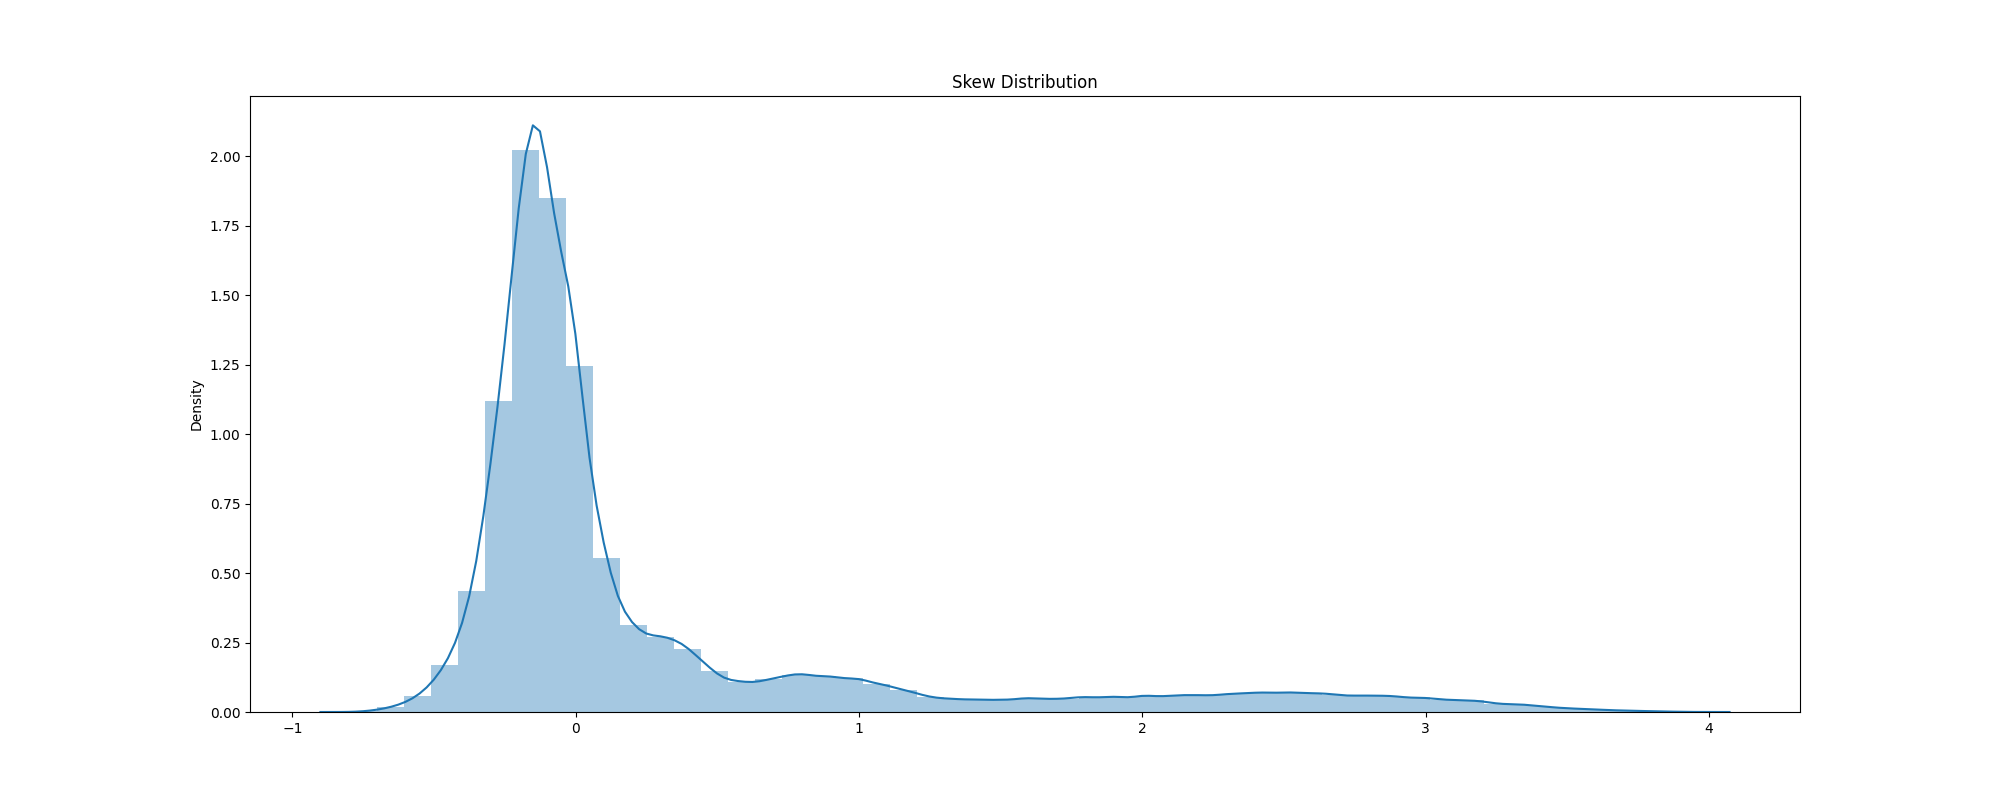

In [27]:
skew_df_2 = skew_df.toPandas()

fig, ax = plt.subplots(figsize = (20,8))
skew_plot = seaborn.distplot(skew_df_2)
ax.set_title('Skew Distribution')
%matplot plt

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph. 

No, the skew visualization shows a ***positive*** skew which tails are in positive direction. \
The mean of positively skewed data will be greater than the median. \
It can be understanded as reviewers who left a written response were more satisfied than normal.

# Should the Elite be Trusted? 

For the final portion - you have a choice:

* Try and analyze some interesting dimension to this data. The **ONLY** requirement is that you must use the **Users** dataset and join on either the **business* or **reviews** dataset
* Or, you may try and answer the question posed: how accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating.

Feel free to use any and all methodologies at your disposal - only requirement is you must render one visualization in your analysis

Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [145]:
df1 = spark.read.json('s3://sta9760yelpdatasetsky/yelp/yelp_academic_dataset_business.json')
df2 = spark.read.json('s3://sta9760yelpdatasetsky/yelp/yelp_academic_dataset_review.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [146]:
df3 = spark.read.json('s3://sta9760yelpdatasetsky/yelp/yelp_academic_dataset_user.json')
df3.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

In [54]:
# User look
# df3.createOrReplaceTempView("user")
# output = spark.sql('select user_id, name, elite, average_stars, cool,fans, useful,review_count from user where elite !=" " limit 5')
# output.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------+--------------------+-------------+-----+----+------+------------+
|             user_id|     name|               elite|average_stars| cool|fans|useful|review_count|
+--------------------+---------+--------------------+-------------+-----+----+------+------------+
|q_QQ5kBBwlCcbL1s4...|     Jane|2006,2007,2008,20...|         3.85|11291|1357| 15038|        1220|
|dIIKEfOgo0KqUfGQv...|     Gabi|2007,2008,2009,20...|         4.09|18046|1025| 21272|        2136|
|D6ErcUnFALnCQN4b1...|    Jason|           2010,2011|         3.76|  130|  16|   188|         119|
|JnPIjvC0cmooNDfsa...|      Kat|2009,2010,2011,20...|         3.77| 4035| 420|  7234|         987|
|37Hc8hr3cw0iHLoPz...|Christine|      2009,2010,2011|         3.72| 1124|  47|  1577|         495|
+--------------------+---------+--------------------+-------------+-----+----+------+------------+

In [ ]:
# To join the review star to elite

In [147]:
df_business = df1.withColumnRenamed('stars',"business_stars")
df_review = df2.withColumnRenamed('stars',"review_stars")
df_business_join_review = df_business.join(df_review, on=['business_id'], how='inner')
df_business_user_review = df3.join(df_business_join_review, on=['user_id'], how='inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [148]:
df_business_user_review.select('business_id','business_stars','review_stars','user_id','elite').sort('business_id','user_id').filter(df_business_user_review['elite'] != '').show(10)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+------------+--------------------+--------------------+
|         business_id|business_stars|review_stars|             user_id|               elite|
+--------------------+--------------+------------+--------------------+--------------------+
|--0zrn43LEaB4jUWT...|           1.0|         1.0|Du8CplP209Es9T3FY...|                2008|
|--164t1nclzzmca7e...|           4.0|         3.0|1P9BpFZ_d3PGCdytD...|      2010,2011,2012|
|--164t1nclzzmca7e...|           4.0|         5.0|3d4fac-e3Plyib8QU...|2017,2018,2019,20,20|
|--164t1nclzzmca7e...|           4.0|         4.0|4ZfHbIbmyTuCX0BXN...| 2012,2013,2014,2015|
|--164t1nclzzmca7e...|           4.0|         5.0|5GHfNK-pcCYJon1cS...|                2010|
|--164t1nclzzmca7e...|           4.0|         5.0|5GHfNK-pcCYJon1cS...|                2010|
|--164t1nclzzmca7e...|           4.0|         1.0|8P8dgzKDQg7OSlEiA...|     2018,2019,20,20|
|--164t1nclzzmca7e...|           4.0|         4.0|8XlB-J73QOFV91Y0e...

In [149]:
df_business_user_review = df_business_user_review.withColumn('difference',(((df_business_user_review['review_stars']-df_business_user_review['business_stars'])*-1)/df_business_user_review['business_stars'])*100)
df_business_user_review = df_business_user_review.select('business_id','business_stars','review_stars','difference','user_id','elite').sort('business_id').filter(df_business_user_review.elite!='')
df_business_user_review.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+------------+----------+--------------------+--------------------+
|         business_id|business_stars|review_stars|difference|             user_id|               elite|
+--------------------+--------------+------------+----------+--------------------+--------------------+
|--0zrn43LEaB4jUWT...|           1.0|         1.0|      -0.0|Du8CplP209Es9T3FY...|                2008|
|--164t1nclzzmca7e...|           4.0|         5.0|     -25.0|llksdcDyLTNkiibAQ...|2009,2010,2011,20...|
|--164t1nclzzmca7e...|           4.0|         1.0|      75.0|Jgxz4UF56FK0taE4i...|           2012,2013|
|--164t1nclzzmca7e...|           4.0|         5.0|     -25.0|WJDYWvNrnMx2PWgfK...|                2012|
|--164t1nclzzmca7e...|           4.0|         4.0|      -0.0|DA90NhtNTNpXxdrXI...|2010,2011,2012,20...|
|--164t1nclzzmca7e...|           4.0|         2.0|      50.0|A9-iDWYBSM4MtolTz...| 2014,2015,2016,2017|
|--164t1nclzzmca7e...|           4.0|         3.0|      25.0|Lhn

In [150]:
df_business_user_review.describe(['difference']).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+
|summary|        difference|
+-------+------------------+
|  count|           2169088|
|   mean|-4.350569024167467|
| stddev| 30.29839006240463|
|    min|            -400.0|
|    max|              80.0|
+-------+------------------+

In [151]:
df_business_user_review_plot = df_business_user_review.select('difference').toPandas()
df_business_user_review_plot.plot.hist(bins=50)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

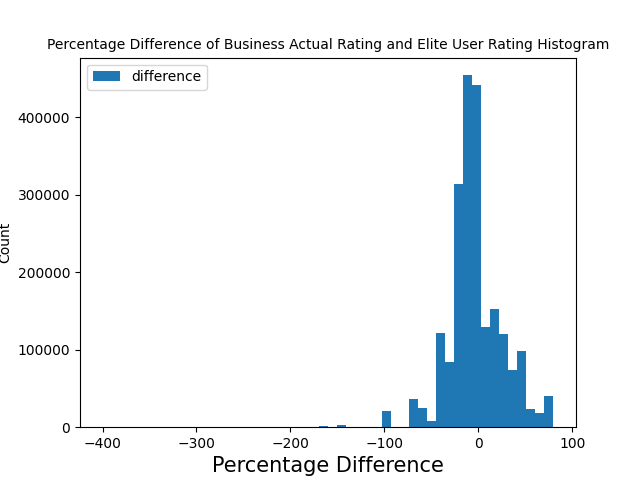

In [152]:
plt.xlabel('Percentage Difference',fontsize=15)
plt.ylabel('Count',fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Percentage Difference of Business Actual Rating and Elite User Rating Histogram',fontsize=10)

%matplot plt

In [ ]:
# Compare to nonelite....

In [122]:
df1 = spark.read.json('s3://sta9760yelpdatasetsky/yelp/yelp_academic_dataset_business.json')
df2 = spark.read.json('s3://sta9760yelpdatasetsky/yelp/yelp_academic_dataset_review.json')
df3 = spark.read.json('s3://sta9760yelpdatasetsky/yelp/yelp_academic_dataset_user.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [134]:
df_business = df1.withColumnRenamed('stars',"business_stars")
df_review = df2.withColumnRenamed('stars',"review_stars")
df_business_join_review = df_business.join(df_review, on=['business_id'], how='inner')
df_business_user_review = df3.join(df_business_join_review, on=['user_id'], how='inner')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [136]:
df_business_user_review.select('business_id','business_stars','review_stars','user_id','elite').sort('business_id','user_id').filter(df_business_user_review['elite'] == '').show(10)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+------------+--------------------+-----+
|         business_id|business_stars|review_stars|             user_id|elite|
+--------------------+--------------+------------+--------------------+-----+
|--0DF12EMHYI8XIgo...|           4.5|         5.0|4NXvQ0bjbcpU0LW1n...|     |
|--0DF12EMHYI8XIgo...|           4.5|         5.0|YFAFZsD_-x8O_7tdl...|     |
|--0DF12EMHYI8XIgo...|           4.5|         5.0|bj5IdqQ8M09xJo1B3...|     |
|--0DF12EMHYI8XIgo...|           4.5|         5.0|dF09N5TYcKOwTlhxz...|     |
|--0DF12EMHYI8XIgo...|           4.5|         1.0|hliUuVm4vGVdODfRQ...|     |
|--0DF12EMHYI8XIgo...|           4.5|         5.0|vYza0QbNkPUAd0ydK...|     |
|--0r8K_AQ4FZfLsX3...|           5.0|         5.0|0OsSL00kvQvMoOxf9...|     |
|--0r8K_AQ4FZfLsX3...|           5.0|         5.0|1ixRBXu2YUaFoKXFT...|     |
|--0r8K_AQ4FZfLsX3...|           5.0|         5.0|HzbScQ9XNEUrr8B_c...|     |
|--0r8K_AQ4FZfLsX3...|           5.0|         5.0|RB_J91Ur9DlbbH

In [137]:
# Not Elite info
df_business_user_review = df_business_user_review.withColumn('difference',(((df_business_user_review['review_stars']-df_business_user_review['business_stars'])*-1)/df_business_user_review['business_stars'])*100)
df_business_user_review = df_business_user_review.select('business_id','business_stars','review_stars','difference','user_id','elite').sort('business_id')
df_business_user_review.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+------------+------------------+--------------------+-----+
|         business_id|business_stars|review_stars|        difference|             user_id|elite|
+--------------------+--------------+------------+------------------+--------------------+-----+
|--0DF12EMHYI8XIgo...|           4.5|         5.0|-11.11111111111111|4NXvQ0bjbcpU0LW1n...|     |
|--0DF12EMHYI8XIgo...|           4.5|         5.0|-11.11111111111111|bj5IdqQ8M09xJo1B3...|     |
|--0DF12EMHYI8XIgo...|           4.5|         1.0| 77.77777777777779|hliUuVm4vGVdODfRQ...|     |
|--0DF12EMHYI8XIgo...|           4.5|         5.0|-11.11111111111111|vYza0QbNkPUAd0ydK...|     |
|--0DF12EMHYI8XIgo...|           4.5|         5.0|-11.11111111111111|dF09N5TYcKOwTlhxz...|     |
|--0DF12EMHYI8XIgo...|           4.5|         5.0|-11.11111111111111|YFAFZsD_-x8O_7tdl...|     |
|--0r8K_AQ4FZfLsX3...|           5.0|         5.0|              -0.0|1ixRBXu2YUaFoKXFT...|     |
|--0r8K_AQ4FZfLsX3...|        

In [143]:
#Not Elite summary
df_business_user_review.describe(['difference']).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+
|summary|          difference|
+-------+--------------------+
|  count|             8635403|
|   mean|-0.08967093748134816|
| stddev|  38.874466446914425|
|    min|              -400.0|
|    max|                80.0|
+-------+--------------------+

In [139]:
df_business_user_review_plot = df_business_user_review.select('difference').toPandas()
df_business_user_review_plot.plot.hist(bins=50)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

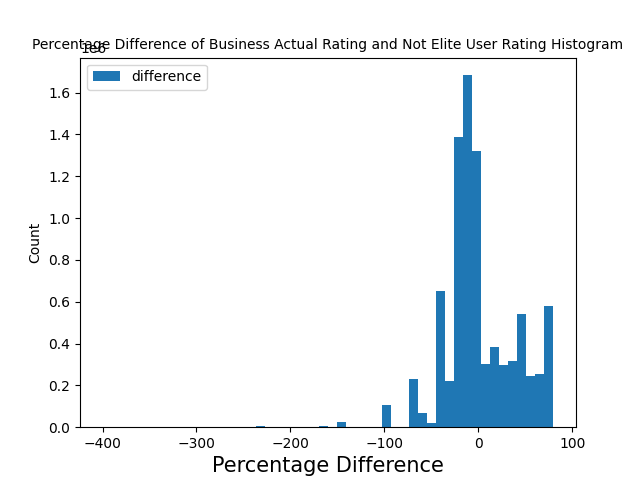

In [142]:
plt.xlabel('Percentage Difference',fontsize=15)
plt.ylabel('Count',fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Percentage Difference of Business Actual Rating and Not Elite User Rating Histogram',fontsize=10)

%matplot plt

## Conclusion
#### By the summary and graphs, they show that the elite provides stars that have less standard deviation than non elite. Although there are 4 times more non elite data than elite, the standard deviation of percentage difference for non elite is still higher than elite people.
#### Based on their mean, they are pretty much even on giving extreme positive or extreme negative stars. The elite tends to leave a slight negative impact like -4.35% than actual business_star. 
#### Based on graph, the non-elite people tends to give more negative review_stars than actual business_stars.

### All in all, we shall always trust the elite! Or trust elite more than non elite.

